In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import h5py
import os,sys
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
import glob
import copy
import re
import pickle

# Prelim

First, define some helper functions to compute chi_effective and chi_p

In [2]:
def Calculate_Xp(m1, m2, a1, a2, costilt1, costilt2):
    
    q = m2/m1
    sintilt1 = np.sqrt(1-(costilt1)**2)
    sintilt2 = np.sqrt(1-(costilt2)**2)
    
    return np.maximum(a1*sintilt1, (3.+4.*q)/(4.+3.*q)*q*a2*sintilt2)

def Calculate_Xeff(m1, m2, a1, a2, costilt1, costilt2):
    Xeff = (m1*a1*costilt1 + m2*a2*costilt2)/(m1+m2)
    return Xeff

def eta(m1,m2):
    return m1*m2/(m1+m2)/(m1+m2)

def Mc(m1,m2):
    return np.power(eta(m1,m2),3./5.)*(m1+m2)

Note that the LALInference prior is uniform in *luminosity* distance, and uniform in *detector-frame* component masses. This corresponds to:

\begin{equation}
p_\mathrm{lal}(m_1,m_2,z) \propto (1+z)^2 D_L^2(z) \left( D_c(z) + \frac{c(1+z)}{H(z)}\right),
\end{equation}

where $D_L(z)$ and $D_c(z)$ are the luminosity and comoving distance at redshift $z$, respectively, and $H(z)$ is the Hubble parameter at $z$. Below, we'll define a few functions to compute this prior so that it can be removed, allowing us to hierarchically fit for the true redshift distribution or later impose our own astrophysically-motivated prior.

In [3]:
# Define constants
# Note that we assume a cosmology identical to that in pesummary
c = 299792458 # m/s
H_0 = 67900.0 # m/s/MPc
Omega_M = 0.3065 # unitless
Omega_Lambda = 1.0-Omega_M
year = 365.25*24.*3600

# Construct custom cosmology matching pesummary
cosmo = Planck15.clone(name='cosmo',Om0=Omega_M,H0=H_0/1e3,Tcmb0=0.)

def Hz(z):
    return H_0*np.sqrt(Omega_M*(1.+z)**3.+Omega_Lambda)

def calculate_pLAL(z, dl):
    dc = dl/(1.+z) # comoving distance 
    pLAL = np.power(1.+z,2.)*np.power(dl,2.)*(dc+c*(1.+z)/Hz(z))
    return pLAL

def dVc_dz(z,dl):
    dc = dl/(1.+z) # comoving distance 
    dVc_dz = 4*np.pi*c*(dc**2.)/Hz(z) # differential comoving volume 
    return dVc_dz

For later use, we'll want to build an interpolant between luminosity distance and redshift:

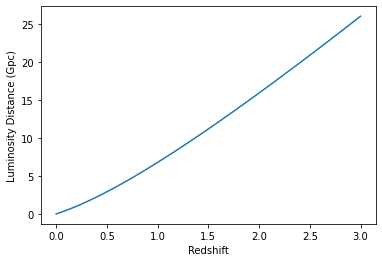

In [4]:
zs_ref = np.linspace(0.,3.,1000)
DL_ref = cosmo.luminosity_distance(zs_ref).to(u.Mpc).value

fig,ax = plt.subplots()
ax.plot(zs_ref,DL_ref/1e3)
ax.set_xlabel('Redshift')
ax.set_ylabel('Luminosity Distance (Gpc)')
plt.show()

Finally, load dictionary we'll use to list events and cut on FAR

In [5]:
eventDict = h5py.File('events.hdf','r')

eventKeyFile = "event_to_run.json"
with open(eventKeyFile,'r') as jf:
    eventKeyDict = json.load(jf)

target_nSamps = 8000

# O1/O2

In [6]:
O1O2_events = np.array([])

# Read all O1 BBHs
for key in eventDict['O1']:
    O1O2_events = np.append(O1O2_events,str(key))

# Read all O2 BBHs
for key in eventDict['O2']:
    if key!='GW170817':
        O1O2_events = np.append(O1O2_events,str(key))
    
print(O1O2_events)

['GW150914' 'GW151012' 'GW151226' 'GW170104' 'GW170608' 'GW170729'
 'GW170809' 'GW170814' 'GW170818' 'GW170823']


In [7]:
for key in O1O2_events:
    
    print(key)
    if os.path.exists(".tmp/{0}.npy".format(key)):
        print("skip")
        continue
    
    # load samples
    #BBH_post = h5py.File('O1O2/GWTC-1_sample_release/{0}_GWTC-1.hdf5'.format(key), 'r')['Overall_posterior']
    BBH_post = h5py.File('../../LIGO-Data/O1O2/GWTC-1_sample_release/{0}_GWTC-1.hdf5'.format(key), 'r')['Overall_posterior']
    m1_DF = BBH_post['m1_detector_frame_Msun']
    m2_DF = BBH_post['m2_detector_frame_Msun']
    a1 = BBH_post['spin1']
    a2 = BBH_post['spin2']
    cost1 = BBH_post['costilt1']
    cost2 = BBH_post['costilt2']
    
    Xeff = Calculate_Xeff(m1_DF,m2_DF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_DF,m2_DF,a1,a2,cost1,cost2)
    DL = BBH_post['luminosity_distance_Mpc']
    
    # Downselect to desired number of samples
    nSamps = min(target_nSamps,Xeff.size)
    print(nSamps)
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_DF = m1_DF[sampleDraws]
    m2_DF = m2_DF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
      
    # Mass ratio
    q = m2_DF/m1_DF

    # Redshift prior
    # Note that DL is the observable, and so our mapping to z is dependent on our presumed cosmology
    z = np.interp(DL,DL_ref,zs_ref)
    Dc = DL/(1.+z)
    p_LAL = calculate_pLAL(z, DL)
    
    # When specifying a new redshift population model downstream, one generally needs
    # the differential comoving volume, dV/dz, for each sample redshift. Precompute this
    dVdz = dVc_dz(z, DL)

    preprocDict = {'Xeff':Xeff,\
                        'Xp':Xp,\
                        'm1':m1_DF/(1.+z),\
                        'm2':m2_DF/(1.+z),\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2,\
                        'z':z,\
                        'z_prior':p_LAL,\
                        'dVc_dz':dVdz
                       }
    
    np.save('.tmp/{0}.npy'.format(key),preprocDict)

GW150914
8000
GW151012
8000
GW151226
8000
GW170104
8000
GW170608
6448
GW170729
5112
GW170809
8000
GW170814
8000
GW170818
5862
GW170823
4278


# O3

In [8]:
O3_events = np.array([])

# GW190425 is a BNS
# GW190426, GW200105, and GW200115 are NSBH candidates
# GW190917 is a mass gap event
to_exclude = ['S190425z','S190426c','S190917u','S200105ae','S200115j']
for key in eventDict['O3']:
    if key not in to_exclude:
        
        # Ignore empty entry mistakenly included in file
        if key=="%s":
            continue
        
        # Select events with FAR<1/yr
        FAR_in_years = float(eventDict['O3'][key]['FAR']['minfar'][()])*year   
        if FAR_in_years<=1.:
            O3_events = np.append(O3_events,str(key))
    
print(len(O3_events))
print(O3_events)

60
['S190408an' 'S190412m' 'S190413ac' 'S190413i' 'S190421ar' 'S190503bf'
 'S190512at' 'S190513bm' 'S190517h' 'S190519bj' 'S190521g' 'S190521r'
 'S190527w' 'S190602aq' 'S190620e' 'S190630ag' 'S190701ah' 'S190706ai'
 'S190707q' 'S190708ap' 'S190719an' 'S190720a' 'S190725t' 'S190727h'
 'S190728q' 'S190731aa' 'S190803e' 'S190805bq' 'S190814bv' 'S190828j'
 'S190828l' 'S190910s' 'S190915ak' 'S190924h' 'S190925ad' 'S190929d'
 'S190930s' 'S191103a' 'S191105e' 'S191109d' 'S191127p' 'S191129u'
 'S191204r' 'S191215w' 'S191216ap' 'S191222n' 'S191230an' 'S200112r'
 'S200128d' 'S200129m' 'S200202ac' 'S200208q' 'S200209ab' 'S200216br'
 'S200219ac' 'S200224ca' 'S200225q' 'S200302c' 'S200311bg' 'S200316bj']


In [9]:
for event in O3_events:
    
    # Look for events in O3a
    if event in eventDict['O3a'].keys():
        
        try:
            #hfile = "O3a/all_posterior_samples/{0}.h5".format(event)
            hfile = "../../LIGO-Data/O3a/all_posterior_samples/{0}.h5".format(event)
            f = h5py.File(hfile,'r')
        
        # If event is not in O3a, it is a new event in O3a-GWTC-2.1
        except OSError:
            gw_name = str(eventDict['O3a'][event]['GWName'][()],'utf-8')
            #hfile = "O3a-GWTC-2.1/IGWN-GWTC2p1-v1-{0}_PEDataRelease.h5".format(gw_name)
            hfile = "../../LIGO-Data/O3a-GWTC-2.1/IGWN-GWTC2p1-v1-{0}_PEDataRelease.h5".format(gw_name)
            f = h5py.File(hfile,'r')
        
    else:
        
        gw_name = str(eventDict['O3b'][event]['GWName'][()],'utf-8')
        #hfile = "O3b/pe_samples/IGWN-GWTC3p0-v1-{0}_PEDataRelease_mixed_nocosmo.h5".format(gw_name)
        hfile = "../../LIGO-Data/O3b/pe_samples/IGWN-GWTC3p0-v1-{0}_PEDataRelease_mixed_nocosmo.h5".format(gw_name)
        f = h5py.File(hfile,'r')
        
    sample_key = eventKeyDict[event]
    BBH_post_samples = f[sample_key]['posterior_samples']
    print(event,hfile,sample_key)
        
    if os.path.exists(".tmp/{0}.npy".format(event)):
        print("skip")
        continue
    
    m1_SF = BBH_post_samples['mass_1_source']
    m2_SF = BBH_post_samples['mass_2_source']
    a1 = BBH_post_samples['a_1']
    a2 = BBH_post_samples['a_2']
    cost1 = BBH_post_samples['cos_tilt_1']
    cost2 = BBH_post_samples['cos_tilt_2']
    DL = BBH_post_samples['luminosity_distance']
    z = BBH_post_samples['redshift']
    
    Xeff = Calculate_Xeff(m1_SF,m2_SF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_SF,m2_SF,a1,a2,cost1,cost2)
            
    nSamps = min(target_nSamps,Xeff.size)
    print(nSamps)
        
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_SF = m1_SF[sampleDraws]
    m2_SF = m2_SF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
    z = z[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
    
    # Mass ratio
    q = m2_SF/m1_SF

    # Redshift and mass priors
    Dc = DL/(1.+z)
    p_LAL = calculate_pLAL(z, DL)
    dVdz = dVc_dz(z,DL)
    
    preprocDict = {'Xeff':Xeff,\
                        'Xp':Xp,\
                        'm1':m1_SF,\
                        'm2':m2_SF,\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2,\
                        'z':z,\
                        'z_prior':p_LAL,\
                        'dVc_dz':dVdz
                       }
    
    np.save('.tmp/{0}.npy'.format(event),preprocDict)

S190408an ../../LIGO-Data/O3a/all_posterior_samples/S190408an.h5 PrecessingSpinIMRHM
8000
S190412m ../../LIGO-Data/O3a/all_posterior_samples/S190412m.h5 PrecessingSpinIMRHM
8000
S190413ac ../../LIGO-Data/O3a/all_posterior_samples/S190413ac.h5 PrecessingSpinIMRHM
8000
S190413i ../../LIGO-Data/O3a/all_posterior_samples/S190413i.h5 PrecessingSpinIMRHM
8000
S190421ar ../../LIGO-Data/O3a/all_posterior_samples/S190421ar.h5 PrecessingSpinIMRHM
8000
S190503bf ../../LIGO-Data/O3a/all_posterior_samples/S190503bf.h5 PrecessingSpinIMRHM
8000
S190512at ../../LIGO-Data/O3a/all_posterior_samples/S190512at.h5 PrecessingSpinIMRHM
8000
S190513bm ../../LIGO-Data/O3a/all_posterior_samples/S190513bm.h5 PrecessingSpinIMRHM
8000
S190517h ../../LIGO-Data/O3a/all_posterior_samples/S190517h.h5 PrecessingSpinIMRHM
8000
S190519bj ../../LIGO-Data/O3a/all_posterior_samples/S190519bj.h5 PrecessingSpinIMRHM
8000
S190521g ../../LIGO-Data/O3a/all_posterior_samples/S190521g.h5 PrecessingSpinIMRHM
8000
S190521r ../../LIG

# Combine

In [10]:
IFAR = np.array([])

# Combine all events with FARs below 1/yr
# Change this to a lower number for a more pure sample
threshold = 1.

# Now find events with FARs below 1/yr
for key in eventDict['O1']:
    far = float(eventDict['O1'][key]['FAR']['minfar'][()])*year
    if far<threshold:
        IFAR = np.append(IFAR,key)

# ...and for O2
for key in eventDict['O2']:
    far = float(eventDict['O2'][key]['FAR']['minfar'][()])*year
    if far<threshold:
        IFAR = np.append(IFAR,key)

# ...and for O3        
for key in eventDict['O3']:
    
    # Ignore key that has glitched into the event list upstream
    if key=="%s":
        continue
    
    far = float(eventDict['O3'][key]['FAR']['minfar'][()])*year
    if far<threshold:
        IFAR = np.append(IFAR,key)

# Load data for events identified above, neglecting BNS and NSBH candidates
sampleDict = {}
to_exclude_deliberately = ["GW170817","S190425z",'S190426c','S190917u','S200105ae','S200115j']
for event in IFAR:
    if event not in to_exclude_deliberately:
        dataDict = np.load(".tmp/{0}.npy".format(event),allow_pickle=True)[()]
        sampleDict[event] = dataDict

with open('sampleDict_FAR_1_in_1_yr.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)


In [11]:
data = np.load('sampleDict_FAR_1_in_1_yr.pickle',allow_pickle=True)
print(data.keys())

dict_keys(['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823', 'S190408an', 'S190412m', 'S190413ac', 'S190413i', 'S190421ar', 'S190503bf', 'S190512at', 'S190513bm', 'S190517h', 'S190519bj', 'S190521g', 'S190521r', 'S190527w', 'S190602aq', 'S190620e', 'S190630ag', 'S190701ah', 'S190706ai', 'S190707q', 'S190708ap', 'S190719an', 'S190720a', 'S190725t', 'S190727h', 'S190728q', 'S190731aa', 'S190803e', 'S190805bq', 'S190814bv', 'S190828j', 'S190828l', 'S190910s', 'S190915ak', 'S190924h', 'S190925ad', 'S190929d', 'S190930s', 'S191103a', 'S191105e', 'S191109d', 'S191127p', 'S191129u', 'S191204r', 'S191215w', 'S191216ap', 'S191222n', 'S191230an', 'S200112r', 'S200128d', 'S200129m', 'S200202ac', 'S200208q', 'S200209ab', 'S200216br', 'S200219ac', 'S200224ca', 'S200225q', 'S200302c', 'S200311bg', 'S200316bj'])


In [12]:
print(data['GW150914'].keys())

dict_keys(['Xeff', 'Xp', 'm1', 'm2', 'a1', 'a2', 'cost1', 'cost2', 'z', 'z_prior', 'dVc_dz'])


In [13]:
# Clean up
files_to_remove = glob.glob(".tmp/*.npy")
for f in files_to_remove:
    os.remove(f)